我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [68]:

import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。使用线性模型参数w=[2,−3.4]⊤、b=4.2和噪声项ϵ生成数据集

In [69]:
def synthetic_data(w, b, num_examples):
    """生成 y= Xw+b+噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))#均值为0，方差为1，1000个样本，列数是w的长度
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)#加入均值为0，方差为0.01的噪音
    return X, y.reshape((-1, 1))#把x,y做成列向量返回

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features 中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值（一个标量）

In [70]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.5482, -0.2148]) 
label: tensor([1.8350])


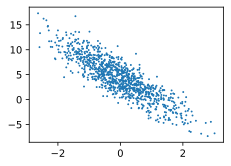

In [71]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(),1)

定义一个data_iter 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [72]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))#随机生成一些样本
    random.shuffle(indices)#样本的下标打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.9307,  0.0853],
        [ 1.8149,  0.5498],
        [-0.9153,  1.4606],
        [ 0.2108,  1.3123],
        [ 0.5072,  0.1562],
        [-0.2992,  0.4035],
        [ 0.1748,  0.8891],
        [ 0.4056, -0.9838],
        [-0.5524, -0.3329],
        [ 0.2179, -1.1478]]) 
 tensor([[ 2.0591],
        [ 5.9625],
        [-2.5974],
        [ 0.1617],
        [ 4.6866],
        [ 2.2393],
        [ 1.5256],
        [ 8.3394],
        [ 4.2178],
        [ 8.5416]])


定义 初始化模型参数

In [86]:
w = torch.normal(0, 0.01, size=(2, 1),requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [74]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [75]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [76]:
def sgd(params, lr, batch_size):#给定参数，学习率，小批量
    """小批量随机梯度下降"""
    with torch.no_grad():#不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size#学习率乘以梯度，除掉之前的损失函数没有除的小批量
            param.grad.zero_()#将梯度设为0，以免下次计算时累积梯度


训练过程

In [77]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)#X和y的小批量损失
        l.sum().backward()#因为l的形状是（batch_size,1),而不是一个标量，要先求和再算梯度
        sgd([w, b], lr ,batch_size)#使用参数的梯度更新
    with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss{float(train_l.mean()):f}')

epoch 1, loss0.030859
epoch 2, loss0.000111
epoch 3, loss0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [87]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 1.9881, -3.4091], grad_fn=<SubBackward0>)
b的估计误差：tensor([4.2000], grad_fn=<RsubBackward1>)
